In [17]:
import datetime
import os
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split

In [ ]:
def load_activities(df, path, file_name='activities.csv'):
    activities = pd.read_csv(data_dir + 'activities.csv')
    activities = activities[['id', 'Brand', 'Functional Owner', 'Program']]
    activities.rename(columns={'id': 'activity'}, inplace=True)
    
    df['activity_short'] = df['activity'].str.split('/').str[-1]
    df = pd.merge(left=df, right=activities, how='left', on='activity')
    
    return df

In [2]:
def load_file(path, file_name):
    df = pd.read_csv(path + file_name)
    
    cols = ['activity', 'duration', 'completion', 'Is Manager', 'Is New Starter']
    actor_df = df.groupby('actorId')[cols].agg({'activity': 'count',
                                                'duration': 'sum',
                                                'completion': 'sum',
                                                'Is Manager': 'last',
                                                'Is New Starter': 'first'
                                                }).reset_index()
       
    actor_df['actorId'] = actor_df['actorId'].str.split('|').str[-1]
    actor_df['date'] = file_name.replace('.csv', '')

    return actor_df

In [3]:
# Loop individual json files
data_dir = './data/'
file_list = [file for file in os.listdir(data_dir) if file.endswith('.csv')]
file_list = [file for file in file_list if file != 'activities.csv']
# file_list = file_list[:30]

In [4]:
data = [load_file(data_dir, x) for x in file_list]

C:\Users\mnelo\anaconda3\envs\py_cpu\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\mnelo\anaconda3\envs\py_cpu\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (12,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df = pd.concat(data)

In [6]:
df.head()

,actorId,activity,duration,completion,Is Manager,Is New Starter,date
0,00030190-dcc0-11ea-892f-13bace717482,20,321363,0.0,N,N,2021-07-01
1,00082fb1414f9f1513402b02ee0fbc703bc30418c4be55...,1,832,1.0,N,N,2021-07-01
2,003e7061b23d9b921a4d3500105e76e848c65572f160e4...,22,93299,13.0,N,N,2021-07-01
3,004dd7c1cd54a30e42cdd675f8ca6734361eeeaf65c708...,2,6158,0.0,N,N,2021-07-01
4,00553ab7ac5ea7881594583157d965b82f85dc5820c31b...,4,18846,0.0,N,N,2021-07-01


In [7]:
# Convert to monthly signals
df['month'] = pd.to_datetime(df['date']).dt.month
month_df = df.groupby(['month', 'actorId']).agg({'date': 'max',
                                                 'activity': 'count',
                                                 'duration': ['sum', 'std', 'max', 'min'],
                                                 'completion': 'sum',
                                                 'Is Manager': 'last',
                                                 'Is New Starter': 'first'
                                                }).reset_index()

month_df.head()

month                                   actorId        date activity  \
                                                          max    count   
0     1  ++URvSHxYSVFVyJzCFsqdQlbL3kGUCF/8jlFdw==  2022-01-29        5   
1     1  +/csvrFBc/t8FWAxShxrNk0ZaT1EHm8xvHcLNg==  2022-01-28       10   
2     1  +/fzgrqv6MN0i/6u0oT3rNWB8KLWgPepJO+Trg==  2022-01-27        1   
3     1  +0QBtNua0kHlSj9vEkAxbxBGO2wQQDBuj/gs5w==  2022-01-02        1   
4     1  +0SMEs+CgvpV/InYoviO16nyh9eq/IbYVZ7i3w==  2022-01-27        2   

  duration                                 completion Is Manager  \
       sum            std      max     min        sum       last   
0   725260  168312.003825   410273    2774       10.0          Y   
1  2768861  392158.272830  1103128    6000        2.0          Y   
2    33541            NaN    33541   33541        1.0          Y   
3   123145            NaN   123145  123145        0.0          N   
4   600355  404815.096695   586425   13930        1.0          N   

  Is New Starter  
           first  
0              N  
1              N  
2              N  
3              N  
4              N

In [8]:
cols = ['month', 'actorId', 'date', 'activity', 'duration_sum', 'duration_std', 'duration_max', 'duration_min',  
        'completion', 'manager', 'starter']
month_df.columns = cols

In [9]:
# Transform month for cyclical feature
month_df['month_sin'] = np.sin((month_df['month'] - 1)*(2.*np.pi/12))
month_df['month_cos'] = np.cos((month_df['month'] - 1)*(2.*np.pi/12))
month_df['date'] = pd.to_datetime(month_df['date'])

In [10]:
month_df.sort_values(['actorId', 'date'], inplace=True)
month_df.head()

,month,actorId,date,activity,duration_sum,duration_std,duration_max,duration_min,completion,manager,starter,month_sin,month_cos
242834,5,++9x+R2W6d3bmO29wJLkvMKT77vDkeC+Xyj8LA==,2022-05-31,3,498009,188265.498233,383083,47408,15.0,N,N,8.660254e-01,-5.000000e-01
526029,9,++IXItP1roBROE0cZzVGHGI0SBRsPEgWm1AsEQ==,2021-09-29,2,399042,270421.674756,390738,8304,5.0,N,N,-8.660254e-01,-5.000000e-01
599388,10,++IXItP1roBROE0cZzVGHGI0SBRsPEgWm1AsEQ==,2021-10-26,3,524836,126057.167818,287347,38652,16.0,N,N,-1.000000e+00,-1.836970e-16
189779,4,++IXItP1roBROE0cZzVGHGI0SBRsPEgWm1AsEQ==,2022-04-24,1,23590,NaN,23590,23590,0.0,N,N,1.000000e+00,6.123234e-17
385245,7,++R0/LJbYJhMnOm4wpjqvceV47XOmOm3OvGNvw==,2021-07-17,3,256667,139653.362224,246711,0,4.0,N,N,1.224647e-16,-1.000000e+00


In [11]:
dates = [datetime.date(2021, x, 1) - datetime.timedelta(days=1) for x in range(8, 13)] 
dates = dates + [datetime.date(2022, x, 1) - datetime.timedelta(days=1) for x in range(1, 8)]
dates = [pd.to_datetime(x) for x in dates]
dates

[Timestamp('2021-07-31 00:00:00'),
 Timestamp('2021-08-31 00:00:00'),
 Timestamp('2021-09-30 00:00:00'),
 Timestamp('2021-10-31 00:00:00'),
 Timestamp('2021-11-30 00:00:00'),
 Timestamp('2021-12-31 00:00:00'),
 Timestamp('2022-01-31 00:00:00'),
 Timestamp('2022-02-28 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-30 00:00:00'),
 Timestamp('2022-05-31 00:00:00'),
 Timestamp('2022-06-30 00:00:00')]

In [13]:
data_transform = []

for x, y in zip(dates[:-1], dates[1:]):
    feature_filter = month_df['date'] <= x
    #feature_filter = month_df['date'].between(x.replace(day=1), x)
    label_filter = (month_df['date'] > x) & (month_df['date'] <= y)
    
    features = month_df.loc[feature_filter]
    labels = month_df.loc[label_filter, ['actorId', 'completion']]
    
    # Feature engineering
    features = features.groupby('actorId').agg({'date': 'max', 
                                                'activity': 'sum', 
                                                'duration_sum': 'sum',
                                                'duration_std': 'mean',
                                                'duration_max': 'max',
                                                'duration_min': 'min',
                                                'completion': 'sum',
                                                'manager': 'last',
                                                'starter': 'first',
                                                'month_sin': 'last',
                                                'month_cos': 'last'}).reset_index()
    features['recency'] = (x - features['date']).dt.days
    features['manager'] = np.where(features['manager'] == 'Y', 1, 0)
    features['starter'] = np.where(features['starter'] == 'Y', 1, 0)
    features = features[['actorId', 'recency', 'activity', 'duration_sum', 'duration_std',
                         'duration_max', 'duration_min', 'manager', 'month_sin', 'month_cos']]
    
    # Merge with t+1 labels
    new_data = pd.merge(left=features,
                        right=labels,
                        how='left',
                        on='actorId')
    new_data['completion'].fillna(0, inplace=True)
    
    data_transform.append(new_data)
    
df_transform = pd.concat(data_transform)

In [14]:
df_transform.head()

,actorId,recency,activity,duration_sum,duration_std,duration_max,duration_min,manager,month_sin,month_cos,completion
0,++R0/LJbYJhMnOm4wpjqvceV47XOmOm3OvGNvw==,14,3,256667,139653.362224,246711,0,0,1.224647e-16,-1.0,0.0
1,++URvSHxYSVFVyJzCFsqdQlbL3kGUCF/8jlFdw==,26,2,29792,3341.786648,17259,12533,1,1.224647e-16,-1.0,3.0
2,+/1xMsbUkzW4u86e47HHneW+zpLsv8yScwTQGw==,3,3,871526,410326.024056,764312,53110,0,1.224647e-16,-1.0,2.0
3,+/Dj4o6M7FkESTxtGU06Zx9NPmIYSjBu4yhUaQ==,25,1,518194,NaN,518194,518194,0,1.224647e-16,-1.0,0.0
4,+/Sa03htBsFXqt+O9K7dgf6r34jxoteJBM+zjg==,0,2,159410,17099.256183,91796,67614,0,1.224647e-16,-1.0,0.0


In [15]:
df_transform['duration_std'] = df_transform['duration_std'].fillna(0)

In [18]:
# Train/Test split
X = df_transform[['recency', 'activity', 'duration_sum', 'duration_std',
                         'duration_max', 'duration_min',  'manager', 'month_sin', 'month_cos']]
y = df_transform[['completion']].values.reshape(-1)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

In [21]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

from sklearn.preprocessing import LabelEncoder

In [31]:
regressor = TabNetRegressor(verbose=0,seed=42)

X2_train = X_train.to_numpy()
y2_train = y_train.reshape(-1, 1)
X2_test = X_train.to_numpy()
y2_test = y_train.reshape(-1, 1)


regressor.fit(X_train=X2_train, y_train=y2_train,
              eval_set=[(X2_test, y2_test)],
              patience=10, max_epochs=100,
              eval_metric=['rmse'])


Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_rmse = 15.87477
Best weights from best epoch are automatically used!


In [ ]:
# define the model
clf1_nopreproc = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                                  optimizer_params=dict(lr=2e-2),
                                  scheduler_params={"step_size":10, # how to use learning rate scheduler
                                                    "gamma":0.9},
                                  scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                  mask_type='entmax' # "sparsemax"
                                 )

# fit the model 
clf1_nopreproc.fit(x_train, y_train,
                   eval_set=[(x_train, y_train), (x_val, y_val)],
                   eval_name=['train', 'valid'],
                   eval_metric=['auc','accuracy'],
                   max_epochs=1000 , patience=50,
                   batch_size=256, virtual_batch_size=128,
                   num_workers=0,
                   weights=1,
                   drop_last=False
                  )

In [36]:
from pytorch_tabnet.pretraining import TabNetPretrainer

In [40]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    #cat_idxs=cat_idxs,
    #cat_dims=cat_dims,
    #cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    #n_shared_decoder=1, # nb shared glu for decoding
    #n_indep_decoder=1, # nb independent glu for decoding
)

Device used : cpu


In [41]:
unsupervised_model.fit(
    X_train=X2_train,
    eval_set=[X2_test],
    max_epochs=10 , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8,
) 

epoch 0  | loss: 1.22084 | val_0_unsup_loss: 1.13512 |  0:01:43s
epoch 1  | loss: 1.1515  | val_0_unsup_loss: 1.08944 |  0:04:40s
epoch 2  | loss: 1.14727 | val_0_unsup_loss: 1.09611 |  0:08:20s
epoch 3  | loss: 1.14465 | val_0_unsup_loss: 1.07157 |  0:11:10s
epoch 4  | loss: 1.1434  | val_0_unsup_loss: 1.04423 |  0:14:00s
epoch 5  | loss: 1.14319 | val_0_unsup_loss: 1.03539 |  0:16:46s
epoch 6  | loss: 1.1418  | val_0_unsup_loss: 1.0026  |  0:19:31s
epoch 7  | loss: 1.14142 | val_0_unsup_loss: 1.0039  |  0:22:17s
epoch 8  | loss: 1.14028 | val_0_unsup_loss: 1.0055  |  0:24:47s
epoch 9  | loss: 1.14137 | val_0_unsup_loss: 0.99902 |  0:27:12s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_unsup_loss = 0.99902
Best weights from best epoch are automatically used!


In [42]:
reconstructed_X, embedded_X = unsupervised_model.predict(X2_test)

In [45]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X2_test)

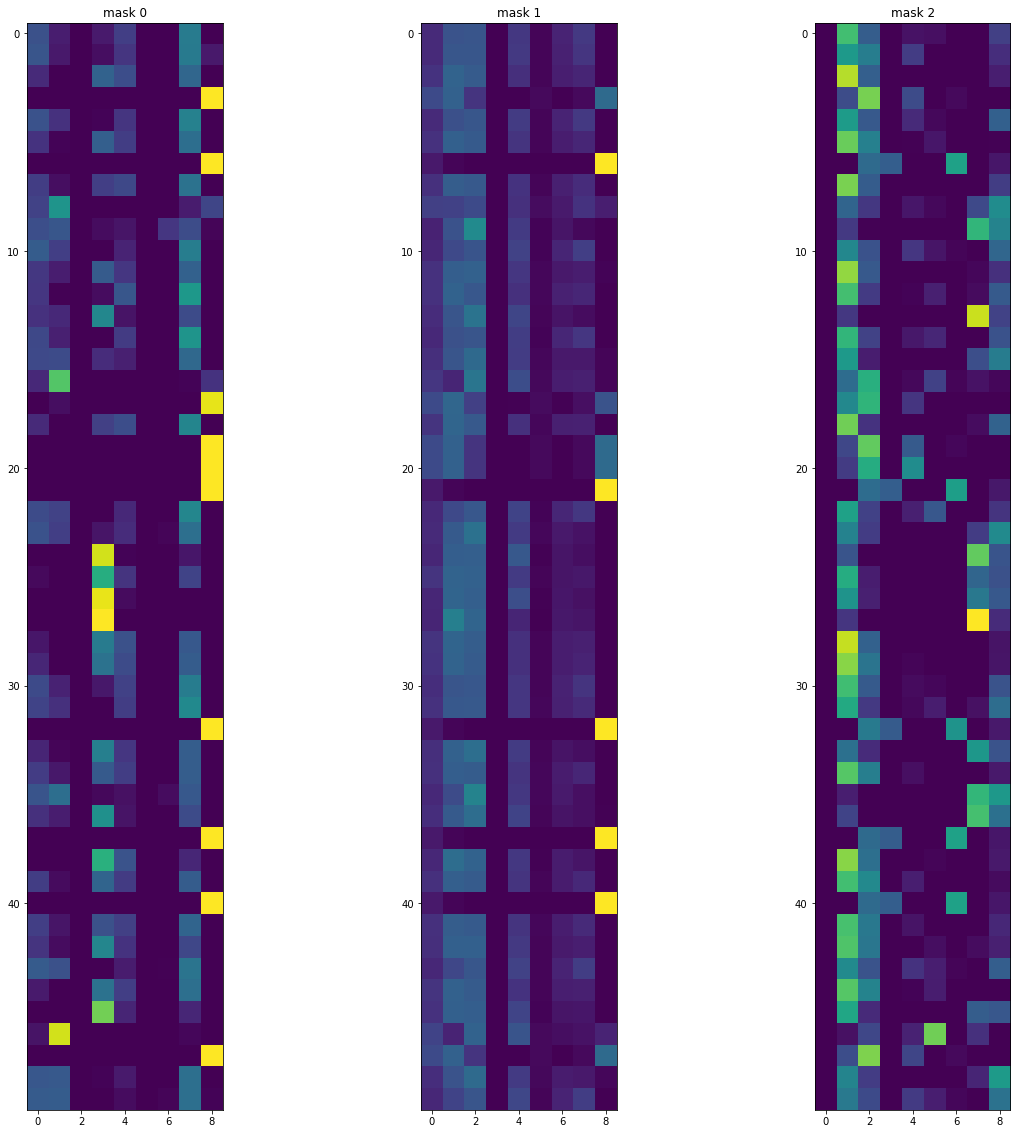

In [47]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [51]:
X2_train.shape

(1187044, 9)

In [52]:
from sklearn.cluster import KMeans

In [53]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embedded_X)
    sse.append(kmeans.inertia_)

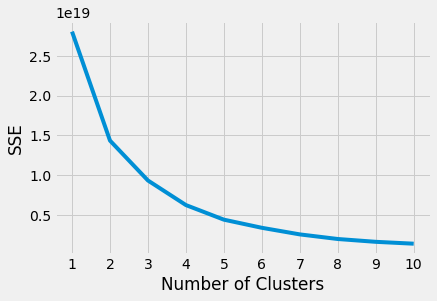

In [54]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [55]:
from kneed import KneeLocator

In [56]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

4

In [64]:
k = kl.elbow + 1
kmeans = KMeans(n_clusters=k).fit(embedded_X)

In [65]:
# Train/Test split
X_actors, X_actors_test, y_train, y_test = train_test_split(df_transform, y, test_size=test_size, random_state=42)

In [66]:
results = X_actors.copy()
results['labels'] = kmeans.labels_
results.head()

,actorId,recency,activity,duration_sum,duration_std,duration_max,duration_min,manager,month_sin,month_cos,completion,labels
119703,fab2fda1d7ef63e3d478a3c082f2b6d69dec74fc2fabd6...,63,10,1915577,139177.746397,440643,26765,0,-1.000000,-1.836970e-16,0.0,0
110976,ebb00b255ea2c9d05d516249ea8fd9796d00ca75014f10...,34,3,134368,18313.358526,71952,16363,0,-1.000000,-1.836970e-16,0.0,0
24112,40e99e2daf1b109aafedc99301197961e1b5bd71060572...,24,9,1986230,333873.172238,997642,0,0,-0.866025,5.000000e-01,0.0,0
70409,d04a4a90-9029-11ea-805f-7f733ee09eac,5,3,174006,56225.595706,103108,23593,0,-0.500000,-8.660254e-01,2.0,0
37370,5997dc16957c07f89f99275b3e2baa514eeb5ff696b805...,99,6,292843,41850.114845,112081,682,0,-0.866025,5.000000e-01,0.0,0


In [70]:
final = results.groupby('labels').agg({'actorId':'count', 
                               'recency':['min', 'max', 'mean', 'std'],
                               'activity':['min', 'max', 'mean', 'std'],
                               'duration_sum':['min', 'max', 'mean', 'std'],
                               'manager':['min', 'max', 'mean', 'std'],
                               'month_sin':['min', 'max', 'mean', 'std'],
                               'month_cos':['min', 'max', 'mean', 'std'],
                               'completion':['min', 'max', 'mean', 'std']
                              })
print(final)

       actorId recency                            activity                   \
         count     min  max       mean        std      min  max        mean   
labels                                                                        
0       951105       0  334  62.709988  68.048891        1  301    6.280518   
1        27268       0  316  10.663085  24.809457        5  274   57.307210   
2          330       0   36   1.409091   3.316062       52  301  158.169697   
3       203528       0  329  34.139313  48.008902        1  274   19.814659   
4         4813       0  227   5.572408  17.026201       13  300  100.217744   

                  duration_sum  ... month_sin           month_cos       \
              std          min  ...      mean       std       min  max   
labels                          ...                                      
0        5.614463            0  ... -0.320646  0.657211 -1.000000  1.0   
1       25.656521     10481936  ...  0.202635  0.744827 -1.000000  1.0 